In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import pysindy as ps
import numpy.random as npr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sysidentpy.utils.display_results import results
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

# To ignore UserWarnings
import warnings
warnings.filterwarnings('ignore')

# Import local function
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))

from metrics import get_metrics_df
from narmax.utils import display_nx_model

$$\Large\text{Logistic Map}$$
$$\large x_{n+1} = \lambda x_n (1 - x_n) + \eta_n$$
$$\large \eta_n \sim N(0,10^{-3}) \qquad n \in {0, 1, \dots} \qquad 0 \leq x_0 \leq 1 \qquad 0 < \lambda < 4$$

In [2]:
N = 1000
mu = 3.9
x = np.zeros(N)
x[0] = npr.rand()

for n in range(1, N):
    x[n] = np.clip(mu * x[n-1] * (1 - x[n-1]) + 0.001 * npr.rand(), 0, 1)
sol_terms = [['x', 'x^2']]

print('Lambda', mu)

# Split Gnerated Data into Train-Test
x_train, x_test, n_train, n_test = train_test_split(x, list(range(N)), test_size=0.6, shuffle=False)

Lambda 3.9


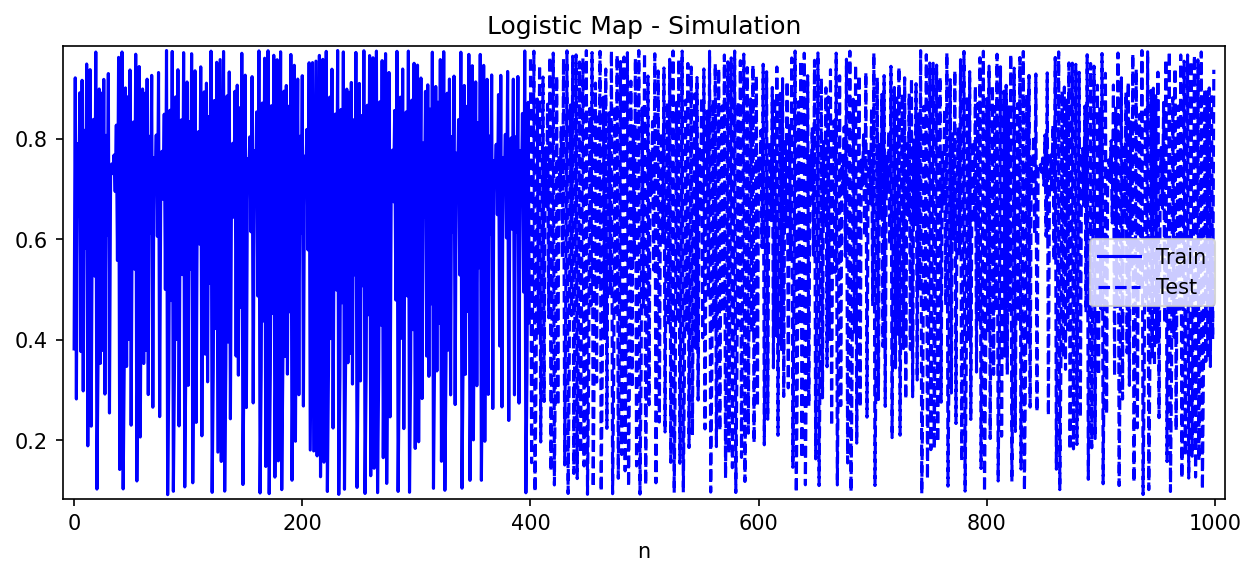

In [3]:
plt.figure(figsize=(10, 4), dpi=150)
plt.title('Logistic Map - Simulation')
plt.margins(0.01, tight=True)
plt.plot(n_train, x_train, 'b', label='Train')
plt.plot(n_test, x_test, 'b--', label='Test')
plt.xlabel('n')
plt.legend()
print(end='')

In [4]:
# Define SINDy Model
sindy_model = ps.SINDy(
    optimizer=ps.STLSQ(threshold=0.5),
    feature_library=ps.PolynomialLibrary(degree=5),
    discrete_time=True,
    feature_names=['x']
)
# Fit model and get time taken
tic = time.time()
sindy_model.fit(x, quiet=True)
toc = time.time()
sindy_time = toc - tic

# Print resulting model
sindy_model.print()

# Simulate SINDy on the test data
sindy_sim = sindy_model.simulate(x_test[0], t=len(n_test))

x[k+1] = 3.902 x[k] + -3.902 x[k]^2


In [5]:
# FROLS: Forward Regression Orthogonal Least Squares algorithm
nx_model = FROLS(
    order_selection=True,
    info_criteria='bic',
    ylag=1, xlag=1,
    estimator='least_squares',
    basis_function=Polynomial(degree=5)
)
# Train model for the state X and get time
tic = time.time()
nx_model.fit(X=np.array(n_train).reshape(-1, 1), y=x_train.reshape(-1, 1))
toc = time.time()
narmax_time = toc - tic
# Get model parameters for the state X and print
coeffs_y = np.pad(nx_model.theta.flatten(), (0, nx_model.basis_function.__sizeof__() - len(nx_model.theta)))
params = results(nx_model.final_model, nx_model.theta, nx_model.err, nx_model.n_terms, dtype='sci')
display_nx_model(params, nx_model.theta, 'x', ['n'])
# Simulate model for the state X
sim_y = nx_model.predict(X=np.array(n_test).reshape(-1, 1), y=x_test[0].reshape(-1, 1))

# Stack results for models and predictions
narmax_model = {}
narmax_model['features'] = ['x']
narmax_model['coeffs'] = np.array([coeffs_y])
narmax_model['regs'] = [[list(eq) for eq in nx_model.final_model]]
narmax_sim = sim_y

x[k+1] = 6.693E-04 1 + 4.391E-03 x[k]^5 + 3.897E+00 x[k] - 3.888E+00 x[k]^2 - 1.341E-02 x[k]^3


In [6]:
# Metrics DataFrame
get_metrics_df(x_test, sol_terms, sindy_model, narmax_model, sindy_sim, narmax_sim, sindy_time, narmax_time)

,CII,COI,L0 Norm,L0 Norm Diff.,Complexity,Forecast Error,MSE,RRSE,Time
SINDy,[True],True,[2],[0],2,0.000815,0.191278,34.629750,0.015638
NARMAX,[True],True,[5],[3],5,0.007919,0.165774,34.312083,0.042006
